In [1]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import sys
import os
from sklearn.base import clone 
# make paths above 'notebooks/' visible for local imports.
# +----------------------------------------------------------------------------+
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.processing import GatherFeatureDatasets
from src.train import TrainStationModel, OptModelSelectionMethods
from src.plotting import plot_r2_heatmap
from src.utils import CrossValidation as cv

# Load Data

In [2]:
proc = GatherFeatureDatasets(is_p=False)
proc.compute_feature_matrix

<function src.processing.SFeatures.compute_feature_matrix(df, freq_max=18, scaler=True, source_dist_type='dist', linear_model=True, w_r=0.5)>

In [3]:
data_dir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/feature_splits'
train = pd.read_csv(f'{data_dir}/s.train.csv')
test = pd.read_csv(f'{data_dir}/s.test.csv')
holdout = pd.read_csv(f'{data_dir}/s.2022.csv')
station_feature_dict, station_meta_dict, feature_names = proc.process_all_stations_datasets(train, 
                                                                  test, 
                                                                  holdout_df=holdout,
                                                                  scaler=False,
                                                                  linear_model=False,
                                                                  source_dist_type='dist')
feature_names

YHB
X shape: (942, 45), y shape: (942,)
X shape: (227, 45), y shape: (227,)
X shape: (92, 45), y shape: (92,)
YHL
X shape: (468, 45), y shape: (468,)
X shape: (114, 45), y shape: (114,)
X shape: (8, 45), y shape: (8,)
YMR
X shape: (1293, 45), y shape: (1293,)
X shape: (303, 45), y shape: (303,)
X shape: (64, 45), y shape: (64,)
YHH
X shape: (883, 45), y shape: (883,)
X shape: (214, 45), y shape: (214,)
X shape: (71, 45), y shape: (71,)
B207
X shape: (314, 45), y shape: (314,)
X shape: (81, 45), y shape: (81,)
FLWY
X shape: (310, 45), y shape: (310,)
X shape: (78, 45), y shape: (78,)
X shape: (10, 45), y shape: (10,)
YPP
X shape: (157, 45), y shape: (157,)
X shape: (44, 45), y shape: (44,)
X shape: (16, 45), y shape: (16,)
YNR
X shape: (1784, 45), y shape: (1784,)
X shape: (454, 45), y shape: (454,)
X shape: (11, 45), y shape: (11,)
YUF
X shape: (725, 45), y shape: (725,)
X shape: (190, 45), y shape: (190,)
X shape: (31, 45), y shape: (31,)
YML
X shape: (421, 45), y shape: (421,)
X shap

array(['amp_ratio_1', 'amp_ratio_2', 'amp_ratio_3', 'amp_ratio_4',
       'amp_ratio_5', 'amp_ratio_6', 'amp_ratio_7', 'amp_ratio_8',
       'amp_ratio_9', 'amp_ratio_10', 'amp_ratio_11', 'amp_ratio_12',
       'amp_ratio_13', 'amp_ratio_14', 'amp_ratio_15', 'amp_ratio_16',
       'amp_ratio_17', 'amp_ratio_18', 'amp_1', 'amp_2', 'amp_3', 'amp_4',
       'amp_5', 'amp_6', 'amp_7', 'amp_8', 'amp_9', 'amp_10', 'amp_11',
       'amp_12', 'amp_13', 'amp_14', 'amp_15', 'amp_16', 'amp_17',
       'amp_18', 'signal_dominant_frequency', 'signal_dominant_amplitude',
       'noise_max_amplitude', 'signal_max_amplitude', 'signal_variance',
       'noise_variance', 'source_depth_km',
       'source_receiver_distance_logkm',
       'source_receiver_back_azimuth_deg'], dtype='<U32')

In [4]:
# Amp 1-3, Signal Variance, Noise Variance, Distance, Back Azimuth, Depth
selected_features = ['amp_1', 'amp_2', 
                     'amp_3', 'signal_variance',
                    'noise_variance', 'source_depth_km',
                    'source_receiver_distance_logkm',
                    'source_receiver_back_azimuth_deg']

In [5]:
selected_feat_dict, selected_feature_names = proc.filter_station_dict_features(station_feature_dict,
                                                                             feature_names,
                                                                             selected_features)

YHB
X_train: (942, 8), X_test: (227, 8), X_holdout: (92, 8)
YHL
X_train: (468, 8), X_test: (114, 8), X_holdout: (8, 8)
YMR
X_train: (1293, 8), X_test: (303, 8), X_holdout: (64, 8)
YHH
X_train: (883, 8), X_test: (214, 8), X_holdout: (71, 8)
B207
X_train: (314, 8), X_test: (81, 8), X_holdout: 0
FLWY
X_train: (310, 8), X_test: (78, 8), X_holdout: (10, 8)
YPP
X_train: (157, 8), X_test: (44, 8), X_holdout: (16, 8)
YNR
X_train: (1784, 8), X_test: (454, 8), X_holdout: (11, 8)
YUF
X_train: (725, 8), X_test: (190, 8), X_holdout: (31, 8)
YML
X_train: (421, 8), X_test: (107, 8), X_holdout: 0
YFT
X_train: (741, 8), X_test: (188, 8), X_holdout: (40, 8)
LKWY
X_train: (203, 8), X_test: (53, 8), X_holdout: 0
YTP
X_train: (382, 8), X_test: (93, 8), X_holdout: (9, 8)
B206
X_train: (196, 8), X_test: (59, 8), X_holdout: 0
YMC
X_train: (1157, 8), X_test: (306, 8), X_holdout: (65, 8)
YNM
X_train: (326, 8), X_test: (70, 8), X_holdout: (33, 8)
YDD
X_train: (216, 8), X_test: (57, 8), X_holdout: (12, 8)


In [6]:
selected_features

['amp_1',
 'amp_2',
 'amp_3',
 'signal_variance',
 'noise_variance',
 'source_depth_km',
 'source_receiver_distance_logkm',
 'source_receiver_back_azimuth_deg']

# Set Parameters

In [7]:
# Model parameters
model = SVR(kernel='rbf')
model_scaler = True
outdir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/s_models'
phase = 'S'
model_selector = OptModelSelectionMethods.select_cv_ind_min_C
model_selector_tol = 0.005

# CV Parameters
cv_random_state = 2652124
cv_folds_inner = 5
svr_C_range= 10**np.arange(-3, 5, dtype=float)
svr_gamma_range = 10**np.arange(-4, 3, dtype=float)
param_grid = [
    {'m__C': svr_C_range, 'm__gamma': svr_gamma_range},
]
scoring_method='r2'
n_jobs_inner = 5
print(param_grid)

[{'m__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]), 'm__gamma': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])}]


# Select hyperparameters, train and evaluate the final model

YHB
YHL
YMR
YHH
B207
FLWY
YPP
YNR
YUF
YML
YFT
LKWY
YTP
B206
YMC
YNM
YDD


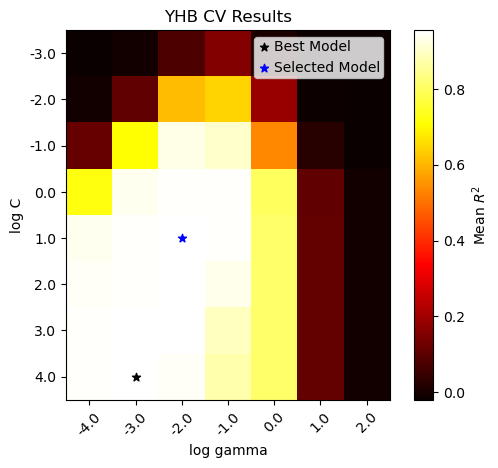

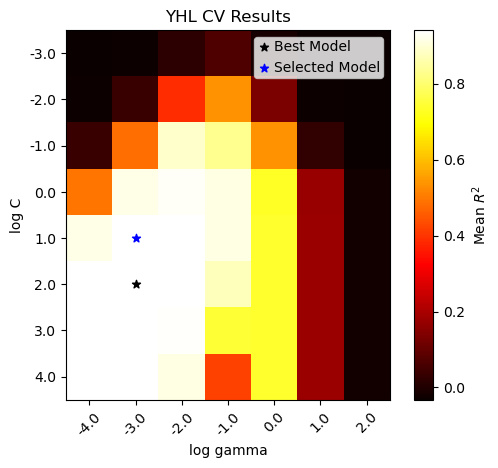

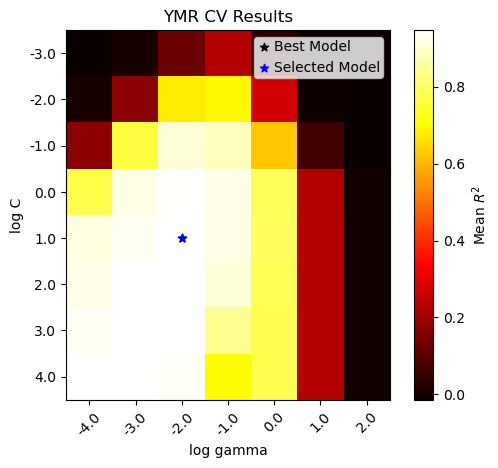

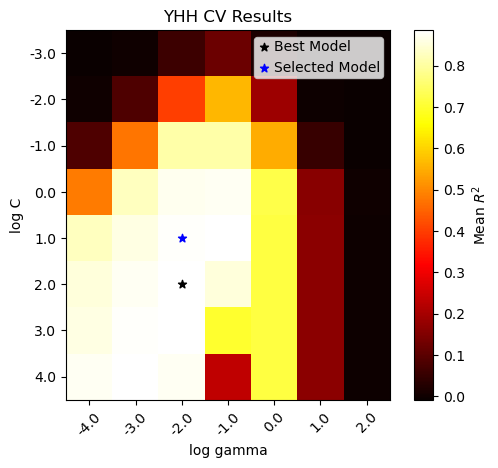

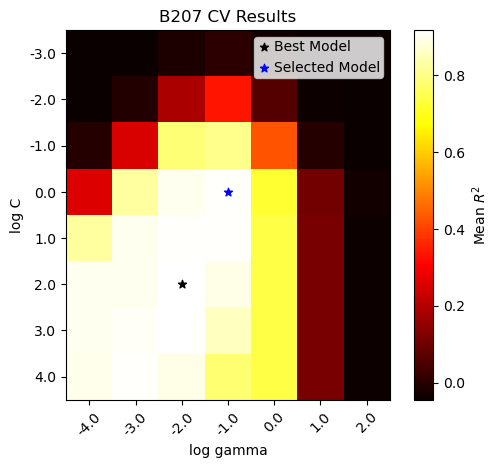

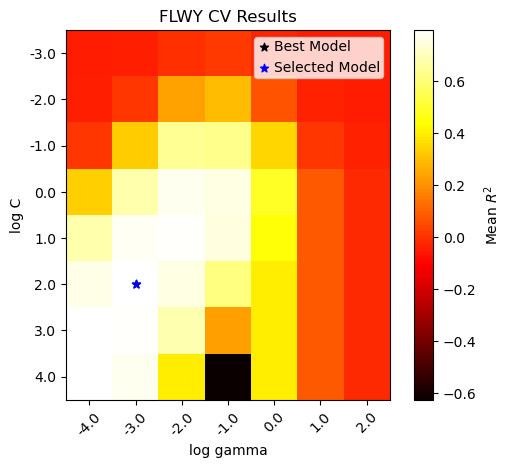

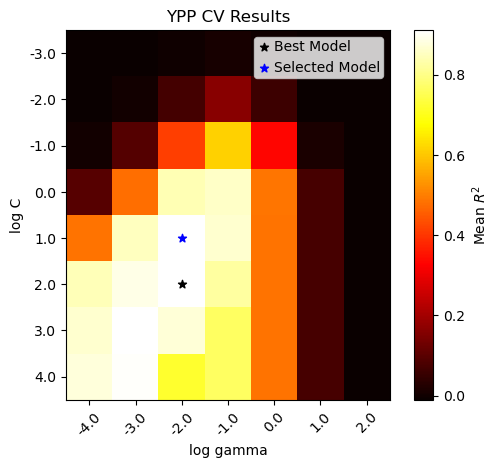

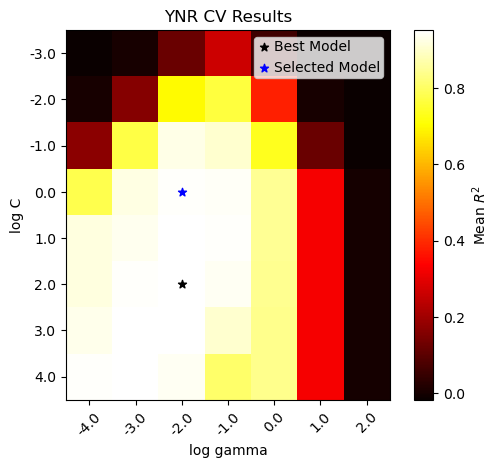

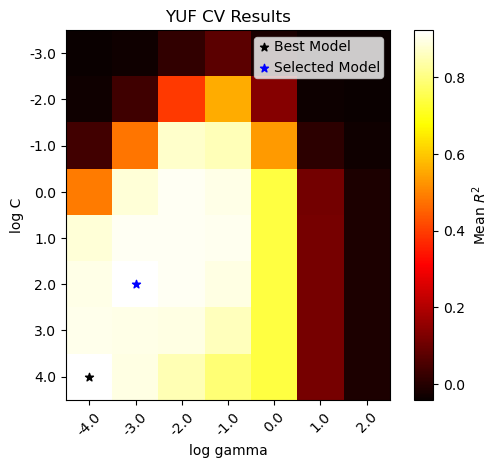

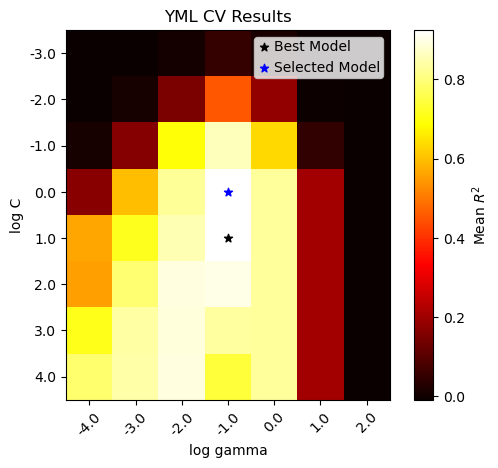

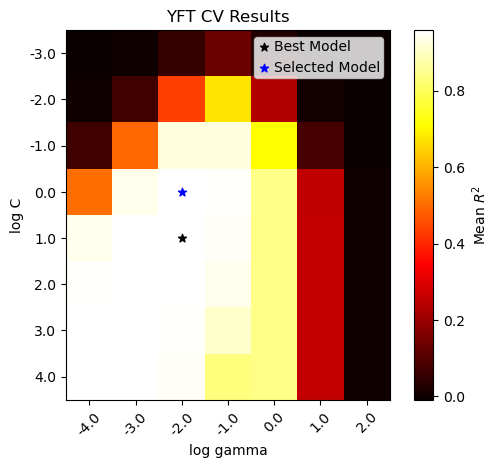

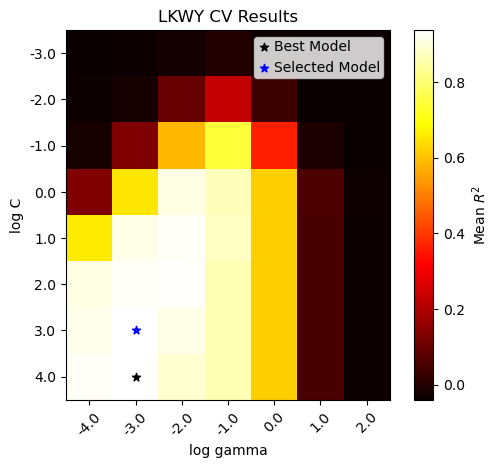

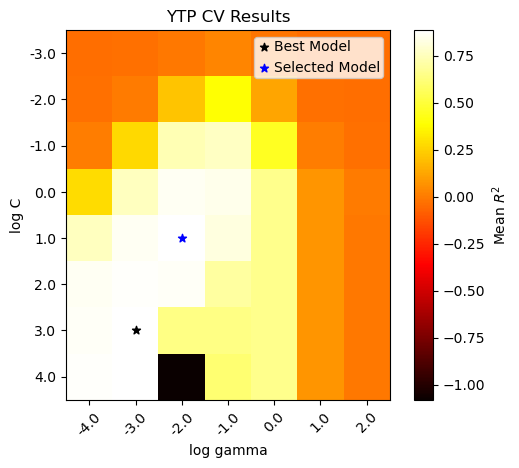

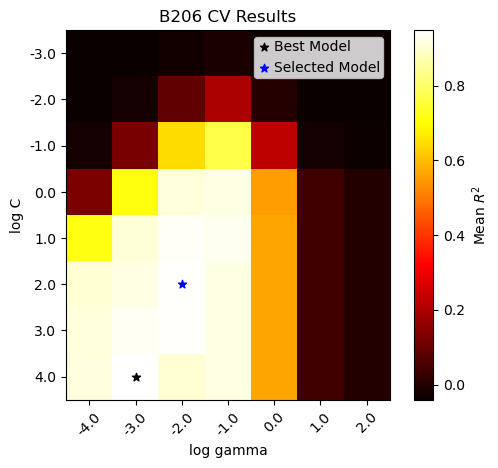

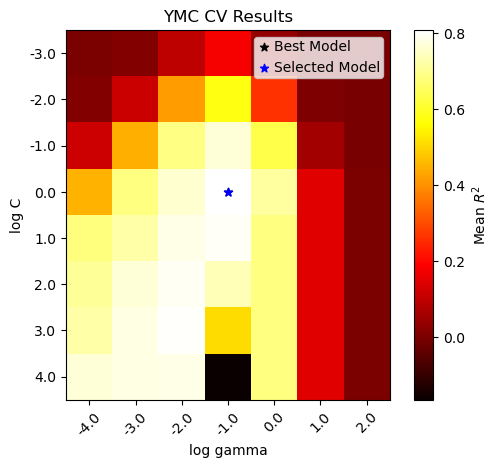

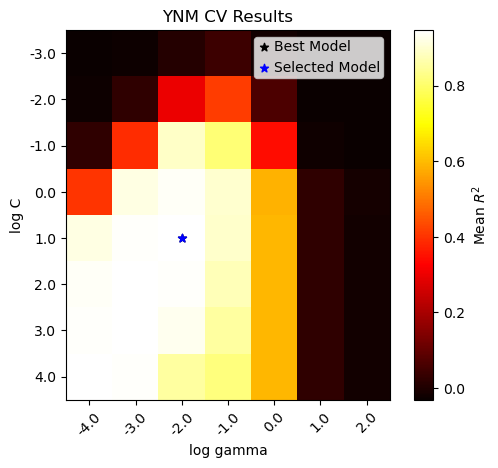

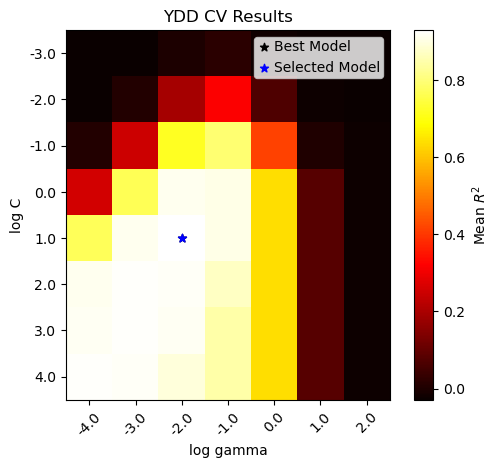

In [8]:
stations = selected_feat_dict.keys()
results_dict_list = []

for station in stations:
    # Set up the grid search
    print(station)
    search, cv_inner = cv.setup_cv(model,
                param_grid,
                model_scaler=model_scaler,
                scoring_method=scoring_method,
                n_jobs=n_jobs_inner,
                cv_folds=cv_folds_inner,
                cv_random_state=cv_random_state,
                refit_model = False)
    
    trainer = TrainStationModel(station,
                                phase,
                                selected_feat_dict[station],
                                station_meta_dict[station])
    
    opt_pipeline = cv.make_simple_pipeline(clone(model), model_scaler)
    gs_results, train_results_dict = trainer.train_model_with_cv(search,
                                                                    opt_pipeline,
                                                                    model_selector_fn=model_selector,
                                                                    model_selector_tol=model_selector_tol
                                                                    )
    all_yhat, eval_results_dict = trainer.eval_all_splits(opt_pipeline)
    results_dict = trainer.format_results_dict(train_results_dict,eval_results_dict)
    trainer.save_all_predictions(all_yhat, outdir)
    trainer.save_model(opt_pipeline, outdir)
    plot_r2_heatmap(gs_results, 
                    svr_C_range,
                    svr_gamma_range,
                    train_results_dict['cv_ind_sel'], 
                    station,
                    outdir=outdir,
                    show=True)
    
    results_dict_list.append(results_dict)
                                        